<a href="https://colab.research.google.com/github/filizolalab/CADD2021/blob/main/BSR3101_Tutorial%20-%20Solubility_prediction_with_Molecular_Graphs_convolutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Solubility prediction with molecular Graph convolutions

*This tutorial is part of the BSR3101 Computer Aided Drug Design, and is based on the [DeepChem tutorials](https://github.com/deepchem/deepchem/tree/master/examples/tutorials). Also check the [DeepChem website](https://deepchem.io/) for other tutorials and documentation.*


#### Background

Poor drug solubility is one of the main obstacles in the drug discovery and development process and was recently identified to be strongly related to the choice of target explored. ([Bergstrom et al., 2016](https://pubmed.ncbi.nlm.nih.gov/26928657/)) Solubility is the driving force for absorption and acceptable solubility in the intestinal fluid is a prerequisite for achieving sufficiently high drug blood concentrations to obtain a therapeutic effect when systemic effects are warranted. The solubility of a compound affects its absorption, distribution, metabolism, excretion and toxicity (ADMET) profile ([Bergstrom et al., 2018](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5861307/)).

We will see how to predict the solubility of small molecules given their 2D chemical structures. 
Classical approaches to this problem use semi-empirical calculations to estimate the solubility from physico-chemical principles, but here we want to use a fully knowledge-based approach, starting from a dataset of measured solubilities for real molecules.  

#### Training data
One of the components of DeepChem is [MoleculeNet](https://moleculenet.org/), a diverse collection of chemical and molecular data sets.  For this tutorial, we can use the [Delaney solubility data set](https://pubs.acs.org/doi/10.1021/ci034243x). The property of solubility in this data set is reported in log(solubility) where solubility is measured in moles/liter.





### Workflow
The basic workflow of model building (not just for deep-learning strategies) is:

1. Prepare the training dataset 
2. Create the model (i.e. make choices about the modeling strategy, functional forms, architecture, etc.)
3. Train the model on the training data: determine the parameters of the model such that it can reproduce the desired output
4. Evaluate the model on an independent test and assess how well the model is able to generalize to new datapoints.
5. Use the model to make predictions about new data.



## Install and import `deepchem`

To run this tutorial the machine where the calculations are executed must have a copy of the deepchem libarary installed. If you're running this on a machine where this is not the case, the library can be installed with the following `pip` command You can of course run this tutorial *locally* if you prefer. In 
this case, don't run the `pip install` cell since it will download and install Anaconda on your local machine. 



In [1]:
!pip install --pre deepchem

     |████████████████████████████████| 609 kB 3.8 MB/s 
     |████████████████████████████████| 20.6 MB 1.3 MB/s 


Now that the `deepchem` library is installed on the machine, we can "import" the `deepchem` package into this notebook, so that the objects and algorithms impelemented in that library can be used.
We can also print the version of `deepchem` that we're using


In [102]:
#import deepchem and print version number
import deepchem as dc
print(dc.__version__)

#import pandas and numpy as well for maths, table management and visualization
import pandas as pd
import numpy as np

#we import the warnings module to fine tune (i.e. suppress) some warnings printed during the training of the neural network
import warnings


2.6.0.dev


## Loading the data





The `deepchem` library makes it very easy to access the datasets in `molnet`. With a single line we can load the desired dataset, and automatically calculate the desired representation (*featurization*) of the molecules. Other available datasets are listed [here](https://deepchem.readthedocs.io/en/latest/api_reference/moleculenet.html).

In this case we want to use a **Graph convolutional network** to model the solubility, and therefore decided to featurize the molecules using Molecular Graphs. Other featurizations (see list [here](https://deepchem.readthedocs.io/en/latest/api_reference/featurizers.html#molecule-featurizers)) include fingerprints, SMILES strings, etc.

Note also that the dataset is already downloaded in three separate sets: a training set, a validation set, and a test set. Each of these serves a different function in the standard deep learning workflow.

In [7]:
# dowload the delaney solubility dataset, featurized with Molecular Graphs, 
# and define three separate objects containing the training, validation, and test datasets

tasks, datasets, transformers = dc.molnet.load_delaney(featurizer='GraphConv')
train_dataset, valid_dataset, test_dataset = datasets

In [97]:
#show a table with the molecule's SMILES and experimental solubility
pd.DataFrame({'id':train_dataset.ids, 
              'solubility':train_dataset.y.flatten()})

,id,solubility
0,CC(C)=CCCC(C)=CC(=O),0.390413
1,CCCC=C,0.090421
2,CCCCCCCCCCCCCC,-2.464346
3,CC(C)Cl,0.704920
4,CCC(C)CO,1.159746
...,...,...
897,CC(=O)OCC(=O)C3(O)CCC4C2CCC1=CC(=O)CCC1(C)C2C(...,-0.649881
898,c3ccc2nc1ccccc1cc2c3,-0.388598
899,Nc2cccc3nc1ccccc1cc23,-0.654719
900,C1CCCCCC1,-0.311180


In [98]:
# how many molecules are there in the training set?
train_dataset.X.shape

(902,)

## Create the model architechture

we create a simple Graph convolutional model. 
See [here](https://deepchem.readthedocs.io/en/latest/api_reference/models.html?highlight=model#model-cheatsheet) for a comprehensive list of other models available in DeepChem.
The only things we have to specify are:
*  the dimensionality of the output (`n_tasks=1`): in this case we only have *one* variable we want to predict, the solubility; 
* whether we want to predict numerical values or dichothomic classifications (`mode='regression'` vs `mode='classification'`).
* the dropout probablity (`dropout=0.2`). [*Dropout*](https://en.wikipedia.org/wiki/Dilution_(neural_networks)) refers to a regularization startegy that helps regucing the risk of overfitting the model.  



In [35]:
model = dc.models.GraphConvModel(n_tasks=1, mode='regression', dropout=0.2)

## Train the model on the training data



We now need to train the model on the data set.  We simply give it the data set and tell it how many epochs of training to perform (that is, how many complete passes through the data to make).

In [36]:
warnings.filterwarnings("ignore", category=UserWarning)
model.fit(train_dataset, nb_epoch=100, all_losses=losses)

0.10820530891418458

## Evaluate the model on an independent test


If everything has gone well, we should now have a fully trained model!  But do we?  To find out, we must evaluate the model on the test set.  We do that by selecting an evaluation metric and calling `evaluate()` on the model.  For this example, let's use the Pearson correlation, also known as r<sup>2</sup>, as our metric.  We can evaluate it on both the training set and test set.

In [38]:
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
print("Training set score:", model.evaluate(train_dataset, [metric], transformers))
print("Test set score:", model.evaluate(test_dataset, [metric], transformers))

Training set score: {'pearson_r2_score': 0.920730486305573}
Test set score: {'pearson_r2_score': 0.6366334912826443}


Notice that it has a higher score on the training set than the test set.  Models usually perform better on the particular data they were trained on than they do on similar but independent data.  This is called "overfitting", and it is the reason it is essential to evaluate your model on an independent test set.

Our model still has quite respectable performance on the test set.  For comparison, a model that produced totally random outputs would have a correlation of 0, while one that made perfect predictions would have a correlation of 1.  Our model does quite well, so now we can use it to make predictions about other molecules we care about.



## Use the model to make predictions about new data.

Let's just use the first 20 molecules from the test set as examples for prediction. For each one we print out the chemical structure (represented as a SMILES string) and the predicted log(solubility). To put these predictions in 
context, we print out the log(solubility) values from the test set as well.

## Predict on subset of test set

In [99]:
test_features = test_dataset.X[:20]
test_values = test_dataset.y[:20]
test_smiles = test_dataset.ids[:20]
test_solubilities = model.predict_on_batch(test_features)

pd.DataFrame({
    'id': test_smiles,
    'predicted logS': test_solubilities.flatten(),
    'exp logS': test_values.flatten()
})

,id,predicted logS,exp logS
0,c1cc2ccc3cccc4ccc(c1)c2c34,-1.802047,-1.601145
1,Cc1cc(=O)[nH]c(=S)[nH]1,0.757377,0.208483
2,Oc1ccc(cc1)C2(OC(=O)c3ccccc23)c4ccc(O)cc4,-0.359628,-0.016027
3,c1ccc2c(c1)cc3ccc4cccc5ccc2c3c45,-1.841653,-2.821917
4,C1=Cc2cccc3cccc1c23,-1.708529,-0.528916
5,CC1CO1,1.834105,1.101683
6,CCN2c1ccccc1N(C)C(=S)c3cccnc23,-0.102714,-0.889874
7,CC12CCC3C(CCc4cc(O)ccc34)C2CCC1=O,-0.801845,-0.526497
8,Cn2cc(c1ccccc1)c(=O)c(c2)c3cccc(c3)C(F)(F)F,-1.042650,-0.763587
9,ClC(Cl)(Cl)C(NC=O)N1C=CN(C=C1)C(NC=O)C(Cl)(Cl)Cl,-0.051225,-0.640204


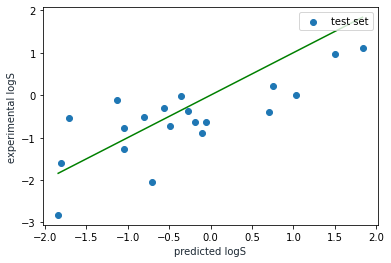

In [106]:
## plot the 
f, ax = plt.subplots()
ax.scatter(test_solubilities, test_values, label='test set')
x = np.array([test_solubilities.min(), test_solubilities.max()])
plt.xlabel('predicted logS', color='#1C2833')
plt.ylabel('experimental logS', color='#1C2833')
plt.plot(x, x, '-g')
plt.legend(loc='upper right');

#### Apply the model to new dataset

In [39]:
!pip install --pre PubChemPy

  Created wheel for PubChemPy: filename=PubChemPy-1.0.4-py3-none-any.whl size=13835 sha256=dc0fdfa248a287b0c1f57be9afe9a25d7a3aa4f2ab6b12580a65e612e6962442
  Stored in directory: /root/.cache/pip/wheels/7c/3d/8c/8192697412e9899dc55bbbb08bbc1197bef333caaa2a71c448
Successfully built PubChemPy


In [ ]:
from pubchempy import get_compounds

In [79]:
results = get_compounds('warfarin', 'name')
for mol in results:
  print((mol.xlogp, mol.isomeric_smiles))

(2.7, 'CC(=O)CC(C1=CC=CC=C1)C2=C(C3=CC=CC=C3OC2=O)O')


In [74]:
data1=[
['acebutolol',-2.20,-2.24,-2.56,-2.11],
['almokalant',-1.17,-2.76,-2.75,-1.70],
['alprenolol',-2.83,-2.42,-2.65,-2.47],
['amiloride',-3.18,-2.29,-3.55,-3.62],
['amitriptyline',-5.14,-4.87,-4.35,-4.51],
['atenolol',-1.30,-1.39,-1.49,-1.59],
['atropine',-1.80,-2.23,-1.50,-1.47],
['benzydamine',-3.78,-4.39,-4.63,-4.27],
['chlorpheniramine',-2.65,-3.60,-3.11,-2.83],
['chlorpromazine',-5.22,-5.11,-4.64,-5.51],
['cimetidine',-1.62,-2.35,-1.25,-2.15],
['clonidine',-0.10,-1.56,-1.44,-1.97],
['desipramine',-3.76,-3.99,-4.05,-3.91],
['erythromycin',-3.14,-3.72,-3.27,-3.10],
['halcion',-4.10,-4.09,-3.71,-4.10],
['imipramine',-4.52,-5.02,-4.20,-5.18],
['ketoconazol',-3.80,-4.92,-5.07,-5.28],
['labetalol',-3.41,-3.75,-4.65,-3.98],
['metoprolol',-1.43,-1.56,-1.31,-1.54],
['miconazol',-5.79,-5.80,-5.80,-6.08],
['minoxidil',-2.04,-1.18,-1.57,-1.69],
['nadolol',-1.57,-1.70,-1.28,-1.56],
['phenazopyridine',-4.53,-3.26,-4.92,-3.67],
['pindolol',-3.88,-2.36,-2.39,-2.42],
['prazosin',-5.08,-3.33,-4.13,-3.72],
['primaquine',-2.52,-2.84,-3.05,-3.09],
['promethazine',-4.34,-4.05,-4.18,-3.85],
['propoxyphene',-4.96,-5.44,-4.76,-5.13],
['propranolol',-3.92,-2.91,-3.21,-3.02],
['quinine',-2.77,-3.64,-3.52,-3.14],
['tamoxifen',-7.55,-7.03,-7.04,-7.27],
['terfenadine',-6.17,-6.92,-6.96,-6.82],
['tirilazad',-7.59,-6.87,-7.57,-7.13],
['trimipramine',-6.29,-5.25,-4.41,-5.40],
['verapamil',-4.69,-5.34,-4.99,-4.43],
['xanax',-3.60,-4.07,-3.95,-4.03],
['alprostadil',-3.67,-4.54,-4.16,-4.15],
['aspirin',-1.75,-2.64,-2.35,-2.51],
['benzoic acid',-1.58,-1.93,-2.44,-1.62],
['diclofenac',-5.56,-4.74,-5.65,-5.08],
['ethinylestradiol',-3.95,-5.49,-4.76,-5.18],
['FA31A',-8.06,-4.98,-5.14,-4.98],
['flurbiprofen',-4.36,-4.15,-4.47,-4.12],
['fluvastatin',-3.83,-5.40,-5.35,-5.07],
['furosemide',-4.75,-4.23,-3.69,-4.23],
['glyburide',-4.82,-6.03,-6.33,-6.33],
['hydrochlorothiazide',-2.70,-3.27,-2.48,-3.66],
['ibuprofen',-3.62,-3.48,-4.44,-3.47],
['indomethacin',-5.20,-5.29,-5.22,-5.32],
['ketoprofen',-3.43,-3.69,-3.95,-3.69],
['naproxen',-4.22,-3.82,-4.02,-3.79],
['phenytoin',-4.12,-4.02,-4.51,-4.39],
['probenecid',-4.90,-4.13,-4.31,-4.15],
['sb209670',-6.77,-6.99,-5.38,-6.86],
['skf105657',-8.76,-6.46,-6.19,-6.50],
['tipranavir',-6.30,-7.40,-7.82,-7.49],
['warfarin',-4.74,-4.40,-4.42,-4.51]]

In [107]:
Bergstroem_smiles = []
Bergstroem_logSexp = []
for mol, logSexp, logS2D, logS3d, logScomb in data1:
   results = get_compounds(mol, 'name')
   for mol in results:
      Bergstroem_smiles.append(mol.isomeric_smiles)
      Bergstroem_logSexp.append(logSexp)


In [84]:
featurizer=dc.feat.ConvMolFeaturizer(per_atom_fragmentation=False)
features = featurizer.featurize(Bergstroem_smiles)

In [85]:
perdicted_solubilities = model.predict_on_batch(features)


array([ 1.8 ,  2.83,  1.17,  0.82, -1.14,  2.7 ,  2.2 ,  0.22,  1.35,
       -1.22,  2.38,  3.9 ,  0.24,  0.86, -0.1 , -0.52,  0.2 ,  0.59,
        2.57, -1.79,  1.96,  2.43, -0.53,  0.12, -1.08,  1.48, -0.34,
       -0.96,  0.08,  1.23, -3.55, -2.17, -3.59, -2.29, -0.69,  0.4 ,
        0.33,  2.25,  2.42, -1.56,  0.05, -0.36,  0.17,  0.17,  0.17,
       -0.75, -0.82,  1.3 ,  0.38, -1.2 ,  0.57, -0.22, -0.12, -0.9 ,
       -2.77, -4.76, -2.3 , -0.74])

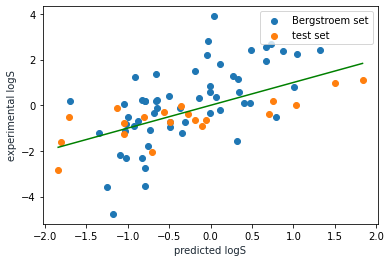

In [114]:
f, ax = plt.subplots()
ax.scatter(perdicted_solubilities, np.array(Bergstroem_logSexp)+4, label='Bergstroem set')
ax.scatter(test_solubilities, test_values, label='test set')
x = np.array([test_solubilities.min(), test_solubilities.max()])
plt.xlabel('predicted logS', color='#1C2833')
plt.ylabel('experimental logS', color='#1C2833')
plt.plot(x, x, '-g')
plt.legend(loc='upper right');

## Done!

You can learn more about DeepChem by checking and following DeepChem on [GitHub](https://github.com/deepchem/deepchem). 
This helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.
